# Analysis of articles about Justin Trudeau using Guardian Media Group API

In [1]:
import pandas as pd
import numpy as np
import urllib.parse
import requests
from scipy import stats
import datetime
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
import seaborn as sns
import schedule
import time
from threading import Timer
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# Reading api-key from file
############################################
text_file = open("api-key.txt", "r")
lines = text_file.readlines()
#
############################################
parameters={
    'from-date' : '2018-01-01',
    'to-date' : str(datetime.today())[:10],
    'q' : 'Justin%20AND%20Trudeau%20OR%20JustinTrudeau',
    'format' : 'json',
    'page' : 1,
    'page-size' : 10,
    'api-key' : lines[0]
}

main_url='https://content.guardianapis.com/search?'

In [3]:
# function to extract data from single page the web site
############################################
#inputs: parameters, web site url
#
############################################
#output: extracted data
#
############################################

def extractData(params, main_urladdress):
    url=main_urladdress+ urllib.parse.urlencode(params).replace('%2520', '%20')
    data= requests.get(url).json()
    if data['response']['status']=='ok':
        return data

In [4]:
fullData = extractData(parameters,main_url)

numberofResults= fullData['response']['total']
numberofPages= fullData['response']['pages']
print('Number of results: {}'.format(numberofResults))
print('Number of pages: {}'.format(numberofPages))

Number of results: 333
Number of pages: 34


In [5]:
# function to append data extracted from each page
############################################
#inputs: parameters, total number of pages, fulldata
#
############################################
#output: None
#
############################################

def appendfullData(params, numPages, fullData):
    for currentpage in range(2, numPages+1):
        parameters['page']= currentpage
        currentData = extractData(parameters,main_url)
        if currentData['response']['results'] is not None:
            fullData['response']['results'].extend(currentData['response']['results'])
        else:
            continue

# 1.
**Extracting information about Justin Trudeau**

In [6]:
appendfullData(parameters, numberofPages, fullData)

In [7]:
# function to extract subset of data from fulldata as table
############################################
#inputs: fulldata
#
############################################
#output: table of required data
#
############################################

def getTableofData(data):
    i=1
    outputDict= {}
    for results in data['response']['results']:
        if results['webPublicationDate'] is not None and results['type'] is not None and results['sectionName'] is not None:
            temp1=str(results['webPublicationDate'])
            temp2=str(results['type'])
            temp3=str(results['sectionName'])
            if i==1:
                outputDict= {'dateandType': [[temp1,temp2,temp3]]}
            else:
                outputDict['dateandType'].append([temp1,temp2,temp3])
            i=i+1
    
    labels = ['Date', 'Type', 'section']
    dataSubset=pd.DataFrame.from_records(outputDict['dateandType'], columns=labels)
    
    return dataSubset

In [8]:
filteredData = getTableofData(fullData)

In [9]:
filteredData.shape

(333, 3)

In [10]:
# function to filter of type article
############################################
#inputs: any dataframe/table
#
############################################
#output: filtered dataframe/table
#
############################################

def filterArticles(data):
    data=data[data['Type']=='article']
    return data

In [11]:
filteredArticlesData = filterArticles(filteredData).copy()

In [12]:
# function to change column data type as pandas datetime data type
############################################
#inputs: any dataframe/table column
#
############################################
#output: datetime data type dataframe/table column
#
############################################

def convertDatefield(data):
    data = data.apply(lambda x: x[0:10])
    data = pd.to_datetime(data)
    return data

In [13]:
filteredData['Date'] = convertDatefield(filteredData['Date'])

In [14]:
filteredArticlesData['Date'] = convertDatefield(filteredArticlesData['Date'])

In [15]:
type(filteredArticlesData['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
# function to group by date and get count per each date
############################################
#inputs: any dataframe/table
#
############################################
#output: grouped dataframe/table
#
############################################

def getArticlesCount(data):
    data = data[['Date', 'Type']].groupby('Date').count() #.sort_values('No. of articles', ascending=False)
    data.reset_index(inplace=True)
    data.columns = ['Date', 'No. of articles']
    return data

In [17]:
articleCounts = getArticlesCount(filteredArticlesData)
sortedarticleCounts = articleCounts.sort_values('No. of articles', ascending=False)

# 2
**Articles about Justin Trudeau that are posted since 01.01.2018 until today**

In [18]:
sortedarticleCounts.head(10)

,Date,No. of articles
68,2018-06-11,13
69,2018-06-12,6
43,2018-04-24,6
66,2018-06-09,6
64,2018-06-07,5
136,2018-11-12,5
65,2018-06-08,4
67,2018-06-10,4
74,2018-06-19,4
41,2018-04-20,4


In [19]:
############################################
#function to build count plot
#
############################################

def countPlot(xvalue, data, figuresize=(15,7)):
    fig, ax = plt.subplots(figsize=figuresize)
    sns.countplot(x=xvalue, data=data, order = data[xvalue].value_counts().index)
    ax.set_title('Value counts for each section', fontsize=30)
    ax.set_xlabel('Section', fontsize=15), ax.set_ylabel('Number of articles', fontsize=15)
    ax.set(yticks= np.arange(0,data[xvalue].value_counts()[0]+1,1))

**Calculating z score for each date and filtering unusual events in the time series**

In [20]:
# function to get z score of a list of values
############################################
#inputs: any dataframe/table column
#
############################################
#output: list of z scores corresponding to input list
#
############################################

def getZscore(data):
    data=stats.zscore(data)
    return data

In [21]:
articlezscore = articleCounts.copy()
articlezscore['z-score']=getZscore(articlezscore['No. of articles'])

In [22]:
# function to filter days with high z score
############################################
#inputs: any dataframe/table
#
############################################
#output: filtered data with high z score
#
############################################

def filterHighZscore(data, score):
    data=data[data['z-score']>score]
    return data

In [23]:
# function to filter days with high z score
############################################
#passing z score corresponding to confidence interval
#(e.g: 1.29 for 90% confidence
#      1.65 for 95% confidence
#      2.33 for 99% confidence
############################################
zconfidence=2.33

highzscoredates=filterHighZscore(articlezscore, zconfidence)['Date']
highzscoreindexes=filteredData[filteredData['Date'].isin(highzscoredates)].index

# 6
**Dates corresponding to unusual events**

In [24]:
highzscoredates.head(5)

43   2018-04-24
64   2018-06-07
66   2018-06-09
68   2018-06-11
69   2018-06-12
Name: Date, dtype: datetime64[ns]

# 4
**Number of articles corresponding to each section**

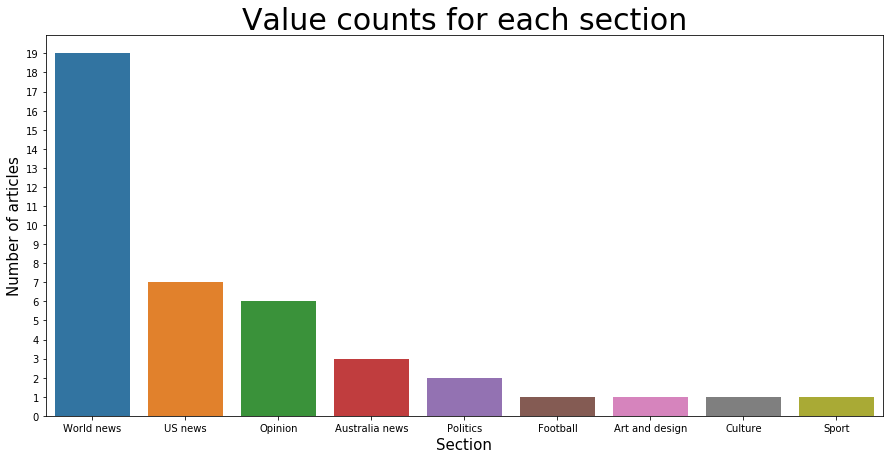

In [25]:
popularDays = filteredArticlesData[filteredArticlesData['Date'].isin(highzscoredates)]
countPlot("section", popularDays)

In [26]:
type(filteredArticlesData['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [27]:
# function to filter days with high z score
############################################
#inputs: any dataframe/table
#
############################################
#output: filtered data with high z score
#
############################################

def convertToTimeSeries(data, start, end):
    idx = pd.period_range(start , end)
    data = data.reindex(idx, fill_value=0)
    return data

In [28]:
# function to fill missing day numbers
############################################
#inputs: any dataframe/table with time and no. of articles
#
############################################
#output: dataframe/table with filled day numbers and no. of articles
#
############################################

def getArticleTimeSeries(data1):
    start = min(data1['Date'])
    end = pd.Timestamp(datetime.today())
    data2 = data1['Type'].groupby(pd.PeriodIndex(data=data1['Date'], freq='D'))
    data2 = data2.count()
    data2 = convertToTimeSeries(data2, start, end)
    return data2

In [29]:
articleCountsList = getArticleTimeSeries(filteredArticlesData)

In [30]:
articleCountsList.head(5)

2018-01-01    1
2018-01-02    0
2018-01-03    1
2018-01-04    0
2018-01-05    0
Freq: D, Name: Type, dtype: int64

In [31]:
# function to convert list to list of dates
############################################
#inputs: list of values
#
############################################
#output: list of values in datetime format
#
############################################

def convertToDate(data):
    data = data.apply(lambda x: pd.to_datetime(str(x)))
    return data

In [32]:
# function to convert transform data with filled time and no. of articles
############################################
#inputs: filteredArticlesData, articleCounts, articleCountsList
#
############################################
#output: dataframe/table with continuous dates and no. of articles
#
############################################

def getArticleTimeSeriesDf(data, data1, data4):
    start = min(data['Date'])
    end = pd.Timestamp(datetime.today())
    data2 = data1.copy()
    data3 = convertToTimeSeries(data2, start, end)
    data3.drop('Date', axis=1, inplace=True)
    data3['No. of articles']= data4.values
    data3.reset_index(inplace=True)
    data3.columns = ['Date', 'No. of articles']
    data3['Date']=convertToDate(data3['Date'])
    return data3

In [33]:
allDaysArticlecounts= getArticleTimeSeriesDf(filteredArticlesData, articleCounts, articleCountsList)

# 3
**Average of all days for the considered period from No. of articles**

In [34]:
allDaysArticlecounts['No. of articles'].mean()

0.7247058823529412

# Time plot

In [35]:
############################################
#function to build time series plot and save it as .png image
#
############################################

def timePlot(df):
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter('%Y-%m')
    days = mdates.DayLocator()

    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(16, 8))

    ax.plot(df['Date'], df['No. of articles'], linewidth=1.5)
    
    ax.set_title('Number of articles about Justin Trudeau', fontsize=30)
    ax.set_xlabel('Time', fontsize=15), ax.set_ylabel('Number of articles', fontsize=15)
    ax.set(xlim=(min(df['Date'])-timedelta(days=5), max(df['Date'])+timedelta(days=5)))
    ax.set(ylim=(-1,max(df['No. of articles'])+2))
    ax.set(yticks= np.arange(0,max(df['No. of articles'])+2,1))

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.xaxis.set_minor_locator(days)
    
    fig.autofmt_xdate()
    
    imageName= 'Justin Trudeau_'+ str(datetime.today())[:10]+'.png'
    fig.savefig(imageName)

# 5
**Evolution of the "No. of articles" over time**

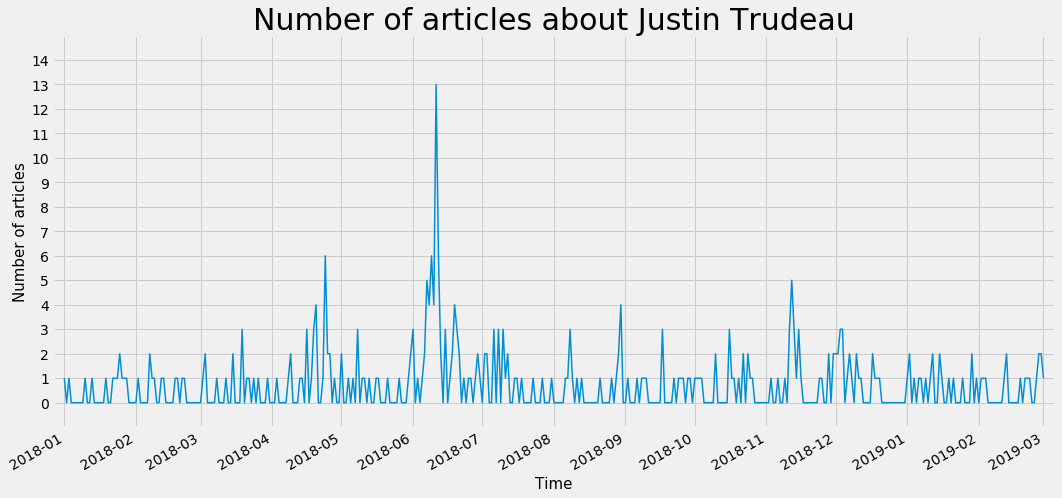

In [36]:
timePlot(allDaysArticlecounts)

In [37]:
# function to extract web titles corresponding to high z scores
############################################
#inputs: highzscoreindexes, filteredData, fullData
#
############################################
#output: dataframe/table with date, time, webtitle data
#
############################################

def extractWebTitles(data1, data2, data3):
    i=0
    data4 = pd.DataFrame(columns=['Date', 'Type', 'Title'], index=range(len(data1)))
    for j in data1:
        data4.iloc[i,0] = data2['Date'][j]
        data4.iloc[i,1] = data2['Type'][j]
        data4.iloc[i,2] = data3['response']['results'][j]['webTitle']
        i=i+1
        
    data4=filterArticles(data4)
    data4.drop('Type', axis=1, inplace=True)
    return data4

In [38]:
webTitlesDf = extractWebTitles(highzscoreindexes, filteredData, fullData)

# 7
**Table of dates with unusual events and corresponding web titles**

In [39]:
webTitlesDf.head(10)

,Date,Title
0,2018-11-12 00:00:00,'Pure joy': refugees fleeing conflict delighte...
1,2018-11-12 00:00:00,Trudeau says Canada has heard Turkish tape of ...
2,2018-06-12 00:00:00,Trump's trade adviser apologizes for saying Tr...
3,2018-06-07 00:00:00,The G7 minus one: Trump packs wrecking ball fo...
4,2018-06-11 00:00:00,"Trudeau 'stabbed us in back' on trade, says Tr..."
5,2018-06-11 00:00:00,'Prepare for the worst': souring Canada-US rel...
6,2018-06-12 00:00:00,Colbert on Trump at the G7: 'Like a toddler wh...
7,2018-06-11 00:00:00,Trump is a bully who thought Canada was weak. ...
8,2018-06-07 00:00:00,Macron calls on G7 members to confront Trump o...
9,2018-11-12 00:00:00,Hancock to tell summit of goal to revolutionis...


In [40]:
############################################
#creating word cloud of words in web titles corresponding to high z scores
#
############################################

def createWordCloud(data):
    groupedNames = data.groupby('Date')['Title'].apply(lambda x: "{%s}" % ' '.join(x))
    fullText=''
    for xiter in groupedNames:
        fullText = fullText+' '+xiter
    wordcloud = WordCloud().generate(fullText)

    wordcloud = WordCloud(background_color="black",max_words=len(fullText),max_font_size=40, relative_scaling=.5).generate(fullText)
    plt.figure(figsize=(13,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# 8
**Showing words which are cause of the unusual events. e.g G7 summit, Trump, trade, US etc.**

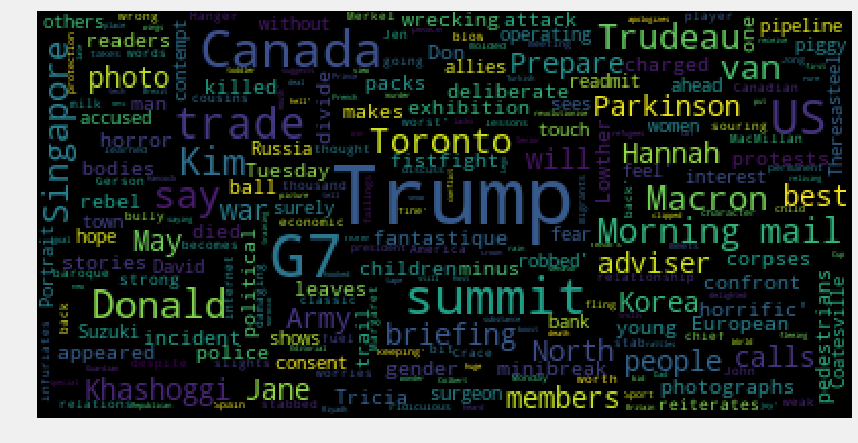

In [41]:
createWordCloud(webTitlesDf)

In [42]:
len(fullData['response']['results'])

333

In [43]:
# function to run in sceduled task
############################################
#inputs: parameters, main_url, fullData=fullData, allDaysArticlecounts
#
############################################
#output: saved time series plot
#
############################################

def repeatjob(parameters=parameters , main_url =main_url, fullData=fullData, 
              allDaysArticlecounts=allDaysArticlecounts):
    
    parameters['from-date']= str(datetime.today())[:10]
    parameters['to-date']= str(datetime.today())[:10]
    parameters['page']= 1

    currentData = extractData(parameters,main_url)
    numberofResults= currentData['response']['total']
    numberofPages= currentData['response']['pages']
    currentPage= currentData['response']['currentPage']
    
    if currentPage==1:
        currentData = extractData(parameters,main_url)
        if currentData['response']['results'] is not None:
            fullData['response']['results'].extend(currentData['response']['results'])   

    if numberofPages>1:
        if extractData(parameters,main_url) is not None:
            appendfullData(parameters, numberofPages, fullData)
        filteredData = getTableofData(fullData)
        filteredArticlesData = filterArticles(filteredData)
        filteredData['Date'] = convertDatefield(filteredData['Date'])
        filteredArticlesData['Date'] = convertDatefield(filteredArticlesData['Date'])
        articleCounts = getArticlesCount(filteredArticlesData)
        
        articleCountsList = getArticleTimeSeries(filteredArticlesData)
        allDaysArticlecounts= getArticleTimeSeriesDf(filteredArticlesData, articleCounts, articleCountsList)
        timePlot(allDaysArticlecounts)
    else:
        timePlot(allDaysArticlecounts)

In [44]:
# function to run in sceduled task
############################################
#inputs: function to be run without parameters/braces(to be given as default in function) and
#       time at which the required function must run format :'hh:mm:ss'
#
############################################
#output: None
#
############################################

def runScheduledTask(function, scheduletime):
    
    schedule.every().day.at(scheduletime).do(function)

    while True:
        schedule.run_pending()
        time.sleep(1)

# Daily automated job

In [ ]:
runScheduledTask(repeatjob, '10:10:00')

# END